<a href="https://colab.research.google.com/github/scsanjay/ml_from_scratch/blob/main/08.%20Decision%20Tree%20Regression/DecisionTreeRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Custom implementation of Decision Tree Regressor

In [ ]:
import numpy as np

In [ ]:
class DecisionTreeRegressor:
  """
  Decision Tree Regression with MSE.

  Parameters
  ----------
  max_depth : int, default=None
    Maximum depth that the tree can have. If None then tree grows till node
    have samples less than min_samples_split or MSE becomes 0.
  
  min_samples_split : int, default = 2
    Minimum number of samples required in the node to be considered
    for next split.
  """

  def __init__ (self, max_depth=None, min_samples_split=2):
    self.max_depth = max_depth
    self.min_samples_split = min_samples_split

  def _get_mse(self, left_node, right_node):
    left_node_n = len(left_node)
    right_node_n = len(right_node)
    total_samples = left_node_n + right_node_n

    # mse of left node
    left_node_mse = np.mean(np.power(left_node-np.mean(left_node), 2))
      
    # mse of right node
    right_node_mse = np.mean(np.power(right_node-np.mean(right_node), 2))

    
    # weigted mse
    weigted_mse = (left_node_mse*left_node_n/total_samples) + \
                            (right_node_mse*right_node_n/total_samples)

    return weigted_mse, total_samples

  def _get_best_split(self, x, y):
    mse = float('inf')
    # transposed, now row represents features
    x_t = x.T
    # loop over each feature
    for j, feature_data in enumerate(x_t):
      feature_data_sorted = np.sort(np.unique(feature_data))
      # try different thresholds
      for i in range(1, len(feature_data_sorted)):
        threshold = (feature_data_sorted[i-1]+feature_data_sorted[i])/2
        thresholded_index = feature_data<=threshold

        left_node_values = y[thresholded_index==True]
        right_node_values = y[thresholded_index==False]
        
        # Get mse based on current childs
        mse_temp, total_samples = self._get_mse(left_node_values, right_node_values)
        
        if (mse_temp<mse):
          mse = mse_temp
          feature_index = j
          feature_threshold = threshold
          samples = total_samples
          
          # create left node
          left_node_data = x[thresholded_index==True]
          left_node = [left_node_data, left_node_values]

          # create right node
          right_node_data = x[thresholded_index==False]
          right_node = [right_node_data, right_node_values]

          # if we get perfect split then mse will be 0
          if mse == 0:
            break
      if mse == 0:
        break
        
    # create node
    result_node = {
        'feature_index':feature_index,
        'feature_threshold':feature_threshold,
        'weighted_mse':mse,
        'samples':samples,
        'childs':[left_node, right_node]
    }
    return result_node

  def _make_leaf_node(self, node1):
    predicted = np.mean(node1[1])
    return predicted

  def _split_tree(self, node, depth=1):
    """recursively build the decision tree"""
    left_node, right_node = node['childs']
    del(node['childs'])

    # if max depth reached then stop growing
    if self.max_depth is not None and depth>=self.max_depth:
      node['left'] = self._make_leaf_node(left_node)
      node['right'] = self._make_leaf_node(right_node)
      return 

    # if weighted_mse = 0 then stop
    if node['weighted_mse'] == 0:
      node['left'] = self._make_leaf_node(left_node)
      node['right'] = self._make_leaf_node(right_node)
      return 

    # work on left child
    if self.min_samples_split>len(left_node[1]):
      node['left'] = self._make_leaf_node(left_node)
    else:
      node['left'] = self._get_best_split(left_node[0], left_node[1])
      self._split_tree(node['left'], depth+1)

    # work on right child
    if self.min_samples_split>len(right_node[1]):
      node['right'] = self._make_leaf_node(right_node)
    else:
      node['right'] = self._get_best_split(right_node[0], right_node[1])
      self._split_tree(node['right'], depth+1)
  
  def _build_tree(self, x,y):
    """get root node and start building the tree"""
    node = self._get_best_split(x, y)
    self._split_tree(node)
    return node
    
  def fit(self, X_train, y_train):
    """
    # It will create the decision tree based on train data

    Parameters
    ----------
    X_train : array of shape (n_samples, n_features)

    Y_train : array of shape (n_samples)

    Returns
    -------
    self : object
    """
    self.tree = self._build_tree(X_train, y_train)
    return self

  def predict(self, X_test):
    """
    It will predict the output for the test data.

    Parameters
    ----------
    X_test : array of shape (n_samples, n_features)

    Returns
    -------
    predictions : array of shape (n_samples,)
    """
    predictions = []
    # loop over each test data
    for x in X_test:
      predicted = self._predict_output(self.tree, x)
      predictions.append(predicted)
    return np.array(predictions)

  def _predict_output(self, node, x):
    """recursively find the leaf node to predict the output"""
    if x[node['feature_index']] <= node['feature_threshold']:
      if isinstance(node['left'], dict):
        return self._predict_output(node['left'], x)
      else:
        return node['left']
    else:
      if isinstance(node['right'], dict):
        return self._predict_output(node['right'], x)
      else:
        return node['right']

## Validation of the custom implementation

In [ ]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

iris = load_boston()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, train_size=.8)

In [ ]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score
import seaborn as sns

In [ ]:
r2_score(y_test, y_pred)

0.8272996525086693

**R2 score is close to 1.**

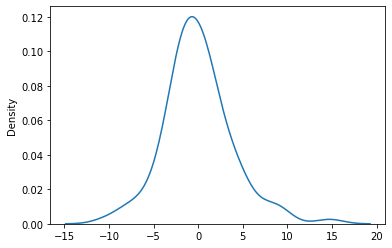

In [ ]:
sns.kdeplot(y_test - y_pred)

**Errors are gaussian distributed.**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

0.8291243009057929

### **R2 is comparable to what we get from sklearn's implementation.**